## Segmenting Brain Tumours with UNet Variants

<img src="https://i.imgur.com/Q8oI4M6.png" 
     align="right" 
     width="300"
     style="padding: 20px;" />

The objective of this notebook is to use different versions of the [UNet](https://arxiv.org/abs/1505.04597) architecture to segment tumours from brain scan images.

We'll begin with the original UNet, then work in some modern computer vision tweaks before building in an attention mechanism. We finish with a model that has 60% of the number of parameters of the original UNet, but with less than half the loss and state of the art performance.

### Loading the Dataset
This dataset stores each input and target pair in a single Python dictionary object, each of which as been saved as a .h5 file, where the image input is saved in the key `image`, and the target segmentation mask is under the key `mask`.

We'll load the paths of our dataset, then each file is stored and formatted.

In [1]:
#!ls /kaggle/input/mri-brain-scans-segmentation/'archive(1)'/BraTS2020_training_data/content/data

In [2]:
import numpy as np
import os
import h5py

# Directory containing .h5 files
#path_to_data = 'data/'  # Change it accordingly 
directory = '/kaggle/input/mri-brain-scans-segmentation/''archive(1)''/BraTS2020_training_data/content/data'
#directory = '/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m'
# Create a list of all .h5 files in the directory
h5_files = [f for f in os.listdir(directory) if f.endswith('.h5')]
print(f"Found {len(h5_files)} .h5 files:\nExample file names:{h5_files[:3]}")

# Open the first .h5 file in the list to inspect its contents
if h5_files:
    file_path = os.path.join(directory, h5_files[25070])
    with h5py.File(file_path, 'r') as file:
        print("\nKeys for each file:", list(file.keys()))
        for key in file.keys():
            print(f"\nData type of {key}:", type(file[key][()]))
            print(f"Shape of {key}:", file[key].shape)
            print(f"Array dtype: {file[key].dtype}")
            print(f"Array max val: {np.max(file[key])}")
            print(f"Array min val: {np.min(file[key])}")
else:
    print("No .h5 files found in the directory.")

Found 57195 .h5 files:
Example file names:['volume_337_slice_56.h5', 'volume_293_slice_67.h5', 'volume_149_slice_44.h5']

Keys for each file: ['image', 'mask']

Data type of image: <class 'numpy.ndarray'>
Shape of image: (240, 240, 4)
Array dtype: float64
Array max val: 20.749972557838987
Array min val: -0.15242355609407895

Data type of mask: <class 'numpy.ndarray'>
Shape of mask: (240, 240, 3)
Array dtype: uint8
Array max val: 0
Array min val: 0


## About the Dataset
Our dataset consists of images from brain scans, as well as masked labels indicating regions of abnormal tissue. Each image has 4 channels.

#### Image channels:
1) **T1-weighted (T1)**: This sequence produces a high resolution image of the brain's anatomy. It's good for visualising the structure of the brain but not as sensitive to tumour tissue as other sequences.

2) **T1-weighted post contrast (T1c or T1Gd)**: After the injection of a contrast agent (usually gadolinium), T1-weighted images are taken again. The contrast agent enhances areas with a high degree of vascularity and blood-brain barrier breakdown, which is typical in tumour tissue, making this sequence particularly useful for highlighting malignant tumours.

3) **T2-weighted (T2)**: T2 images provide excellent contrast of the brain's fluid spaces and are sensitive to edema (swelling), which often surrounds tumours. It helps in visualizing both the tumour and changes in nearby tissue.

4) **Fluid Attenuated Inversion Recovery (FLAIR)**: This sequence suppresses the fluid signal, making it easier to see peritumoral edema (swelling around the tumour) and differentiate it from the cerebrospinal fluid. It's particularly useful for identifying lesions near or within the ventricles.

Regarding the masks, they represent segmentations, containing areas of interest within the brain scans, specifically focusing on abnormal tissue related to brain tumours. We will use these masks for training models in segmenting brain tumours from normal brain tissue. Each mask has 3 channels.

#### Mask channels
1) **Necrotic and Non-Enhancing Tumour Core (NCR/NET)**: This masks out the necrotic (dead) part of the tumour, which doesn't enhance with contrast agent, and the non-enhancing tumour core.

2) **Edema (ED)**: This channel masks out the edema, the swelling or accumulation of fluid around the tumour.

3) **Enhancing Tumour (ET)**: This masks out the enhancing tumour, which is the region of the tumour that shows uptake of contrast material and is often considered the most aggressive part of the tumour.

### Viewing Sample Images
We'll use matplotlib imshow to view some example brain scans, and see the tumour locations.

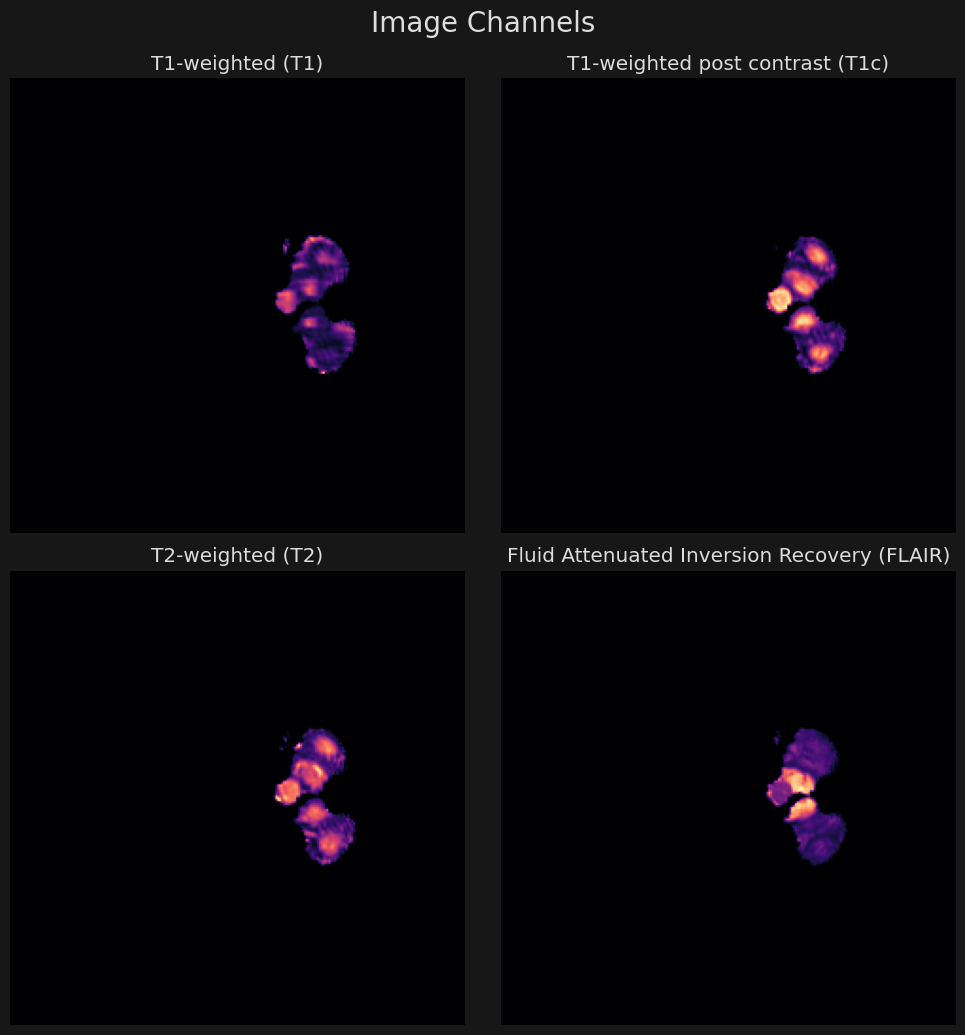

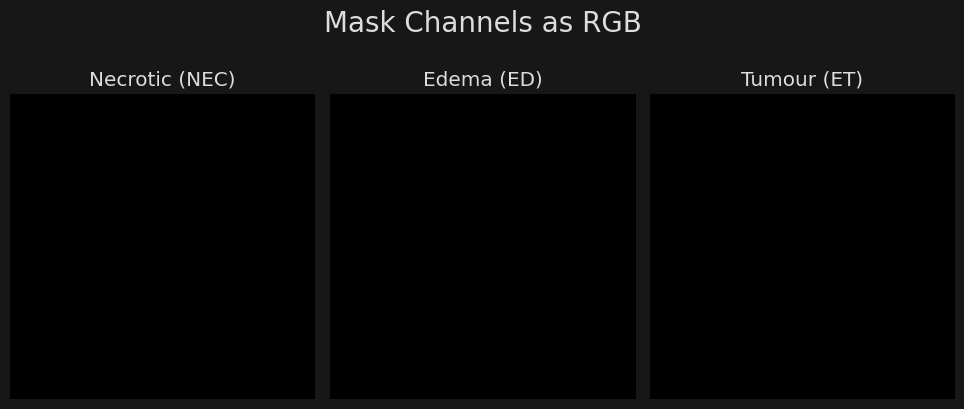

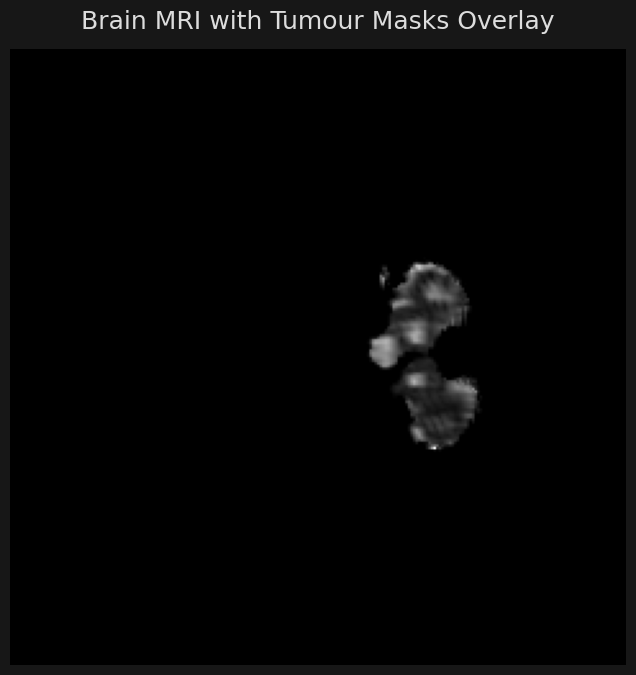

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = '#171717'
plt.rcParams['text.color']       = '#DDDDDD'

def display_image_channels(image, title='Image Channels'):
    channel_names = ['T1-weighted (T1)', 'T1-weighted post contrast (T1c)', 'T2-weighted (T2)', 'Fluid Attenuated Inversion Recovery (FLAIR)']
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for idx, ax in enumerate(axes.flatten()):
        channel_image = image[idx, :, :]  # Transpose the array to display the channel
        ax.imshow(channel_image, cmap='magma')
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.tight_layout()
    plt.suptitle(title, fontsize=20, y=1.03)
    plt.show()

def display_mask_channels_as_rgb(mask, title='Mask Channels as RGB'):
    channel_names = ['Necrotic (NEC)', 'Edema (ED)', 'Tumour (ET)']
    fig, axes = plt.subplots(1, 3, figsize=(9.75, 5))
    for idx, ax in enumerate(axes):
        rgb_mask = np.zeros((mask.shape[1], mask.shape[2], 3), dtype=np.uint8)
        rgb_mask[..., idx] = mask[idx, :, :] * 255  # Transpose the array to display the channel
        ax.imshow(rgb_mask)
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.suptitle(title, fontsize=20, y=0.93)
    plt.tight_layout()
    plt.show()

def overlay_masks_on_image(image, mask, title='Brain MRI with Tumour Masks Overlay'):
    t1_image = image[0, :, :]  # Use the first channel of the image
    t1_image_normalized = (t1_image - t1_image.min()) / (t1_image.max() - t1_image.min())

    rgb_image = np.stack([t1_image_normalized] * 3, axis=-1)
    color_mask = np.stack([mask[0, :, :], mask[1, :, :], mask[2, :, :]], axis=-1)
    rgb_image = np.where(color_mask, color_mask, rgb_image)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_image)
    plt.title(title, fontsize=18, y=1.02)
    plt.axis('off')
    plt.show()
    
    
# Sample image to view
sample_file_path = os.path.join(directory, h5_files[25070])
data = {}
with h5py.File(sample_file_path, 'r') as file:
    for key in file.keys():
        data[key] = file[key][()]

# Transpose the image and mask to have channels first
image = data['image'].transpose(2, 0, 1)
mask = data['mask'].transpose(2, 0, 1)

# View images using plotting functions
display_image_channels(image)
display_mask_channels_as_rgb(mask)
overlay_masks_on_image(image, mask)

### Creating a Dataset and DataLoader
Our dataset is fairly large at ~8GB, so during training we will use dataloaders to load batches of image + target pairs. Since these images are formatted unconventionally, we'll need to build a custom Dataset object and DataLoader. 

Images are stored using the `float64` data type with pixel intensities ranging from ~-0.5 to ~230 and `height`, `width`, `channels` format. The masks use the `uint8` data type and pixels have values of either 0 or 1. 

Our dataloader will need to load an image, reshape it so it's formatted `channels`, `height`, `width` for use in PyTorch, adjust pixel intensities so the minimum value is 0 on every image, then scale each channel so the max is 1, then convert to a `torch.float32` tensor.

### 1 point

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
batch_size = 16
class BrainScanDataset(Dataset):
    def __init__(self, file_paths, deterministic=False):
        self.file_paths = file_paths
        if deterministic:  # To always generate the same test images for consistency
            np.random.seed(1)
        np.random.shuffle(self.file_paths)
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        # Load h5 file, get image and mask
        file_path = self.file_paths[idx]
        with h5py.File(file_path, 'r') as file:
            image = file['image'][()]
            mask = file['mask'][()]
            
            # Reshape: (H, W, C) -> (C, H, W)
            image =  image.transpose(2, 0, 1)
            mask =  mask.transpose(2, 0, 1)
            
            # Adjusting pixel values for each channel in the image so they are between 0 and 255
            for i in range(image.shape[0]):    # Iterate over channels
                desired_min = 0
                desired_max = 255
                min_val = image[i].min()
                max_val = image[i].max() 
                image[i] = (image[i] - min_val) / (max_val - min_val + 1e-10) * (desired_max - desired_min) + desired_min
            
            image = torch.tensor(image, dtype=torch.float32)
            mask = torch.tensor(mask, dtype=torch.float32) 
            
        return image, mask

# Build .h5 file paths from directory containing .h5 files
h5_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.h5')]
np.random.seed(42)
np.random.shuffle(h5_files)

# Split the dataset into train and validation sets (90:10)
split_idx = int(0.9 * len(h5_files))
train_files = h5_files[:split_idx]
val_files = h5_files[split_idx:]

# Create the train and val datasets
train_dataset = BrainScanDataset(train_files)
val_dataset = BrainScanDataset(val_files, deterministic=True)

# Sample dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Use this to generate test images to view later
test_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_input_iterator = iter(DataLoader(val_dataset, batch_size=1, shuffle=False))
# Verifying dataloaders work
for images, masks in train_dataloader:
    print("Training batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    assert images.shape == torch.Size([batch_size, 4, 240, 240])
    assert masks.shape == torch.Size([batch_size, 3, 240, 240])
    break
for images, masks in val_dataloader:
    print("Validation batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    break

Training batch - Images shape: torch.Size([16, 4, 240, 240]) Masks shape: torch.Size([16, 3, 240, 240])
Validation batch - Images shape: torch.Size([16, 4, 240, 240]) Masks shape: torch.Size([16, 3, 240, 240])


In [5]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## The UNet Architecture

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" 
     align="right" 
     width="500"
     style="padding: 20px;" />
     
[UNet](https://arxiv.org/abs/1505.04597) is a deep learning neural network architecture originally designed for image segmentation tasks, but has since found use in GANs and latent diffusion models. Similar to autoencoders, the UNet structures include an encoder for compressing the input into a lower dimensional representation and a decoder for reconstructing the output from this compressed form. However, UNet distinguishes itself from autoencoders with several features:

- **Bottleneck**: At the centre of UNet is the bottleneck layer, situated between the encoder and decoder. This component captures the most abstract representation of the input.

- **Symmetrical Design**: The encoder and decoder parts of UNet are mirror images of each other. This symmetry facilitates the implementation of skip connections, which directly connect layers of the encoder to their corresponding layers in the decoder.

- **Skip Connections**: Unlike conventional autoencoders, UNet incorporates skip connections that can bypass the bottleneck, directly connecting the encoder to the decoder. These connections transfer contextual information from the spatially rich encoder, to the more feature heavy decoder, aiding in the precise localisation necessary for detailed segmentation.

In this project we're going to start off with the original UNet architecture, then work on building in some staple CV tweaks like separable convolution layers, batch norm, fewer activation functions, additive skip connections, larger kernels, then finally include the attention mechanism from [Attention UNet](https://arxiv.org/abs/1804.03999).

In [7]:
def plot_learning_curves(train_epoch_losses, val_epoch_losses, ylim=(0,1)):
    plt.style.use('ggplot')
    plt.rcParams['text.color'] = '#333333'

    fig, axis = plt.subplots(1, 1, figsize=(10, 6))

    # Plot training and validation loss (NaN is used to offset epochs by 1)
    axis.plot([np.NaN] + train_epoch_losses, color='#636EFA', marker='o', linestyle='-', linewidth=2, markersize=5, label='Training Loss')
    axis.plot([np.NaN] + val_epoch_losses,   color='#EFA363', marker='s', linestyle='-', linewidth=2, markersize=5, label='Validation Loss')

    # Adding title, labels and formatting
    axis.set_title('Training and Validation Loss Over Epochs', fontsize=16)
    axis.set_xlabel('Epoch', fontsize=14)
    axis.set_ylabel('Loss', fontsize=14)

    axis.set_ylim(ylim)
    
    axis.legend(fontsize=12)
    axis.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()
    

In [8]:
def display_test_sample(model, test_input, test_target):
    test_input, test_target = test_input.to(device), test_target.to(device)

    # Obtain the model's prediction
    test_pred = torch.sigmoid(model(test_input))
    test_pred = (test_pred > 0.5)
    # Process the image and masks for visualization
    image = test_input.detach().cpu().numpy().squeeze(0)
    mask_pred = test_pred.detach().cpu().numpy().squeeze(0)
    mask_target = test_target.detach().cpu().numpy().squeeze(0)

    # Set the plot aesthetics
    plt.rcParams['figure.facecolor'] = '#171717'
    plt.rcParams['text.color']       = '#DDDDDD'

    # Display the input image, predicted mask, and target mask
    display_image_channels(image)
    display_mask_channels_as_rgb(mask_pred, title='Predicted Mask Channels as RGB')
    display_mask_channels_as_rgb(mask_target, title='Ground Truth as RGB') 


### 2 points

In [9]:
size = 64
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(4, size, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features = size),
            nn.ReLU(),
            nn.Conv2d(size, size, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features = size),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d((2, 2)) # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(size, size*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features = size*2),
            nn.ReLU(),
            nn.Conv2d(size*2, size*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features = size*2),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d((2, 2))  # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(size*2, size*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features = size*4),
            nn.ReLU(),
            nn.Conv2d(size*4, size*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features = size*4),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d((2, 2))  # 64 -> 32

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(size*4, size*8, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features = size*8),
            nn.ReLU(),
            nn.Conv2d(size*8, size*8, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features = size*8),
            nn.ReLU()
        )

        # decoder (upsampling)
        
        self.reduction_channels0 = nn.Conv2d(in_channels=size*8, out_channels=size*4, kernel_size=1)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(size*8, size*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features = size*4),
            nn.ReLU(),
            nn.Conv2d(size*4, size*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features = size*4),
            nn.ReLU()
        )
        
        self.reduction_channels1 = nn.Conv2d(in_channels=size*4, out_channels=size*2, kernel_size=1)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(size*4, size*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features = size*2),
            nn.ReLU(),
            nn.Conv2d(size*2, size*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features = size*2),
            nn.ReLU()
        )
        self.reduction_channels2 = nn.Conv2d(in_channels=size*2, out_channels=size, kernel_size=1)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(size*2, size, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features = size),
            nn.ReLU(),
            nn.Conv2d(size, size, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features = size)
        )

        self.up = nn.UpsamplingBilinear2d(scale_factor=2)
        self.output = nn.Conv2d(size, 3, kernel_size=(1,1), stride=1, padding=0)
        
    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        pool0 = self.pool0(e0)
        e1 = self.enc_conv1(pool0)
        pool1 = self.pool1(e1)
        e2 = self.enc_conv2(pool1)
        pool2 = self.pool2(e2)


        # bottleneck
        b = self.bottleneck_conv(pool2)

        # decoder
        up0 = self.up(b)
        r0 = self.reduction_channels0(up0)
        d0 = self.dec_conv0(torch.cat([r0, e2], 1))

        up1 = self.up(d0)
        r1 = self.reduction_channels1(up1)
        d1 = self.dec_conv1(torch.cat([r1, e1], 1))

        up2 = self.up(d1)
        r2 = self.reduction_channels2(up2)
        d2 = self.dec_conv2(torch.cat([r2, e0], 1))
        x = self.output(d2)
        return x

In [10]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0

    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0


    return iou

In [11]:
def score_model(model, metric, data, num_classes):
    with torch.no_grad():
        model.eval()  # установка режима оценки (evaluation mode)
        class_scores = [0] * num_classes  # инициализация списка для хранения IoU для каждого класса
        class_counts = [0] * num_classes  # список для подсчета количества сэмплов для каждого класса
        for X_batch, Y_batch in data:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            logits = model(X_batch)
            Y_pred = torch.sigmoid(logits)
            Y_pred = (Y_pred > 0.5)

            for class_idx in range(num_classes):
                # выбираем соответствующие каналы для класса и вычисляем метрику IoU
                class_Y_pred = Y_pred[:, class_idx, :, :]
                class_Y_batch = Y_batch[:, class_idx, :, :]
                class_iou = metric(class_Y_pred, class_Y_batch).mean().item()
                class_scores[class_idx] += class_iou
                class_counts[class_idx] += 1

        # вычисляем среднее значение IoU для каждого класса
        class_avg_scores = [score / count if count > 0 else 0 for score, count in zip(class_scores, class_counts)]
    print(f'IoU for Necrosis: {round(class_avg_scores[0], 2)}')
    print(f'IoU for Edema: {round(class_avg_scores[1], 2)}')
    print(f'IoU for Tumor: {round(class_avg_scores[2], 2)}')
    print(f'Average IoU score: {round(sum(class_avg_scores)/num_classes, 3)}')
    #return class_avg_scores

### Training Loop
The code in the cell below defines and executes the training loop for our UNet models. 

The training process involves:
- Setting up the model and training configuration.
- Initialising the model and moving it to the chosen device.
- Adam optimizer for parameter updates and binary cross-entropy loss as the loss function.
- We then iterate through each epoch, we can optionally dynamically adjust the learning rate.

For each epoch, we conduct both training and validation steps:
- In the training step, we feed batches of data to the model, computes the loss, and updates the model parameters.
- In the validation step, we evaluate the model on a separate dataset to monitor performance without updating model parameters.
- We track and print out the average training and validation losses for each epoch, providing insights into the model's learning progress.

Finally, the function returns lists of training and validation losses for further analysis or plotting.

### 2 points

In [12]:
# YOU CAN REWRITE THIS ENTIRE BLOCK

def train_model(model, train_dataloader, val_dataloader, optimizer, loss_fn, scheduler=None, 
                n_epochs=5, train_batches_per_epoch=20, val_batches_per_epoch=20, verbose=True): 
    model.to(device) 

    train_epoch_losses = []
    val_epoch_losses = []
    
    print("Training...")
    for epoch in range(1, n_epochs + 1):
        model.train()
        train_epoch_loss = 0
        for train_batch_idx, (train_inputs, train_targets) in enumerate(train_dataloader, start=1):
            if verbose: print(f"\rTrain batch: {train_batch_idx}/{train_batches_per_epoch}", end='')
            train_inputs =  train_inputs.to(device)
            train_targets =  train_targets.to(device)
            train_preds =  model(train_inputs)
            train_batch_loss =  loss_fn(train_preds, train_targets)
            train_epoch_loss +=  train_batch_loss.item()
            train_batch_loss.backward()
            optimizer.step()  
            optimizer.zero_grad()
            if train_batch_idx >= train_batches_per_epoch:   # if you want lesser batches amount per epoch 
                break
        train_epoch_losses.append(train_epoch_loss/train_batches_per_epoch)
        val_epoch_loss = 0 
        for val_batch_idx, (val_inputs, val_targets) in enumerate(val_dataloader, start=1):
            model.eval()
            with torch.no_grad():
                val_inputs =  val_inputs.to(device)
                val_targets =  val_targets.to(device)
                val_preds =  model(val_inputs)
                val_batch_loss =  loss_fn(val_preds, val_targets)
                val_epoch_loss +=  val_batch_loss.item()
            if val_batch_idx >= val_batches_per_epoch:   # if you want lesser batches amount per epoch 
                break
        val_epoch_losses.append(val_epoch_loss/val_batches_per_epoch)
        if scheduler:
            scheduler.step()
        if verbose:
            print()
            print(f"Epoch: {epoch}, Train loss: {train_epoch_losses[-1]:.6f}, Val loss: {val_epoch_losses[-1]:.6f}\n")
        
    print("Training complete.")
    return [train_epoch_losses, val_epoch_losses]

In [13]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [16]:
model = UNet()

In [17]:
summary(model,
        input_size=(16, 4, 240, 240), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
UNet (UNet)                              [16, 4, 240, 240]    [16, 3, 240, 240]    --                   True
├─Sequential (enc_conv0)                 [16, 4, 240, 240]    [16, 64, 240, 240]   --                   True
│    └─Conv2d (0)                        [16, 4, 240, 240]    [16, 64, 240, 240]   2,368                True
│    └─BatchNorm2d (1)                   [16, 64, 240, 240]   [16, 64, 240, 240]   128                  True
│    └─ReLU (2)                          [16, 64, 240, 240]   [16, 64, 240, 240]   --                   --
│    └─Conv2d (3)                        [16, 64, 240, 240]   [16, 64, 240, 240]   36,928               True
│    └─BatchNorm2d (4)                   [16, 64, 240, 240]   [16, 64, 240, 240]   128                  True
│    └─ReLU (5)                          [16, 64, 240, 240]   [16, 64, 240, 240]   --                   --
├─MaxPool2d (pool0

In [18]:
len(train_dataloader)

3218

In [269]:
def dice_loss(y_pred, y_real):
    eps = 1e-8

    y_prob = F.sigmoid(y_pred)

    intersection = (y_prob * y_real).sum((2, 3))
    dice = (2. * intersection + eps) / (y_prob.sum((2, 3)) + y_real.sum((2, 3)) + eps)

    return (1. - dice).mean()

In [30]:
max_epochs = 10
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, 4, gamma=0.5) # добавим lr-reductor))
history_model = train_model(model, train_dataloader, val_dataloader, optim, nn.BCEWithLogitsLoss(), scheduler=scheduler, n_epochs=max_epochs, train_batches_per_epoch=1000, val_batches_per_epoch=200, verbose=True)

Training...
Train batch: 1000/1000
Epoch: 1, Train loss: 0.007996, Val loss: 0.007777

Train batch: 1000/1000
Epoch: 2, Train loss: 0.006446, Val loss: 0.005768

Train batch: 1000/1000
Epoch: 3, Train loss: 0.005654, Val loss: 0.005221

Train batch: 1000/1000
Epoch: 4, Train loss: 0.005243, Val loss: 0.006057

Train batch: 1000/1000
Epoch: 5, Train loss: 0.004695, Val loss: 0.009473

Train batch: 1000/1000
Epoch: 6, Train loss: 0.004521, Val loss: 0.004666

Train batch: 1000/1000
Epoch: 7, Train loss: 0.004319, Val loss: 0.004260

Train batch: 1000/1000
Epoch: 8, Train loss: 0.004162, Val loss: 0.003958

Train batch: 1000/1000
Epoch: 9, Train loss: 0.004002, Val loss: 0.004265

Train batch: 1000/1000
Epoch: 10, Train loss: 0.003845, Val loss: 0.004086

Training complete.


In [72]:
from IPython.display import FileLink
import pickle

In [19]:
#torch.save(model.state_dict(), 'model_weights_unet1.pth')
model.load_state_dict(torch.load('/kaggle/input/unet1-weights/model_weights_unet1.pth'))

<All keys matched successfully>

In [39]:
with open('losses_unet1.pkl', 'wb') as f:
    pickle.dump((history_model[0], history_model[1]), f)

In [38]:
FileLink(r'model_weights_unet1.pth') 

/kaggle/working/model_weights_unet1.pth

In [40]:
FileLink(r'losses_unet1.pkl') 

/kaggle/working/losses_unet1.pkl

In [26]:
score_model(model, iou_pytorch, test_dataloader, 3)

IoU for Necrosis: 0.83
IoU for Edema: 0.8
IoU for Tumor: 0.86
Average IoU score: 0.83


### Learning Curves
Here we visualise the training and validation loss over each epoch, helping assess the model's learning progress and identify overfitting.

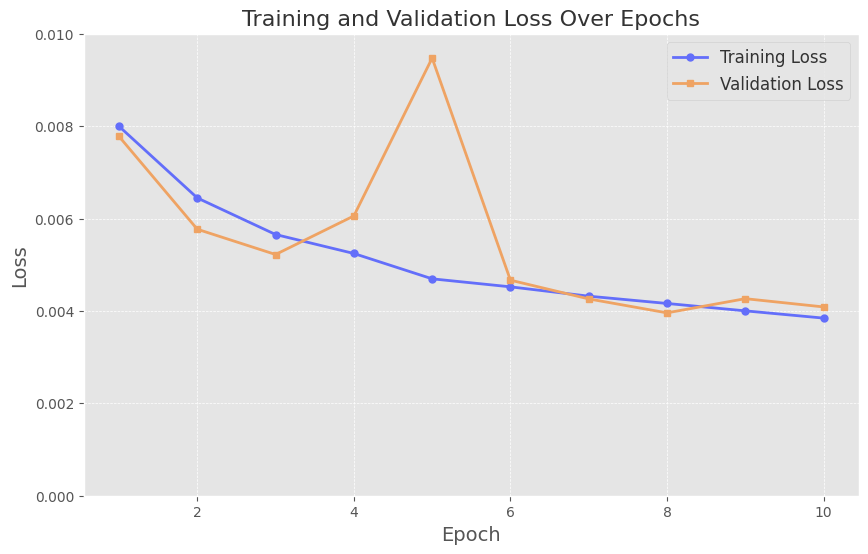

In [42]:
plot_learning_curves(history_model[0], history_model[1], (0, 0.01))

### Viewing a Sample Prediction
This code demonstrates the model's performance on a test sample by displaying the input brain MRI images, the model's predicted mask, and the actual mask (ground truth).

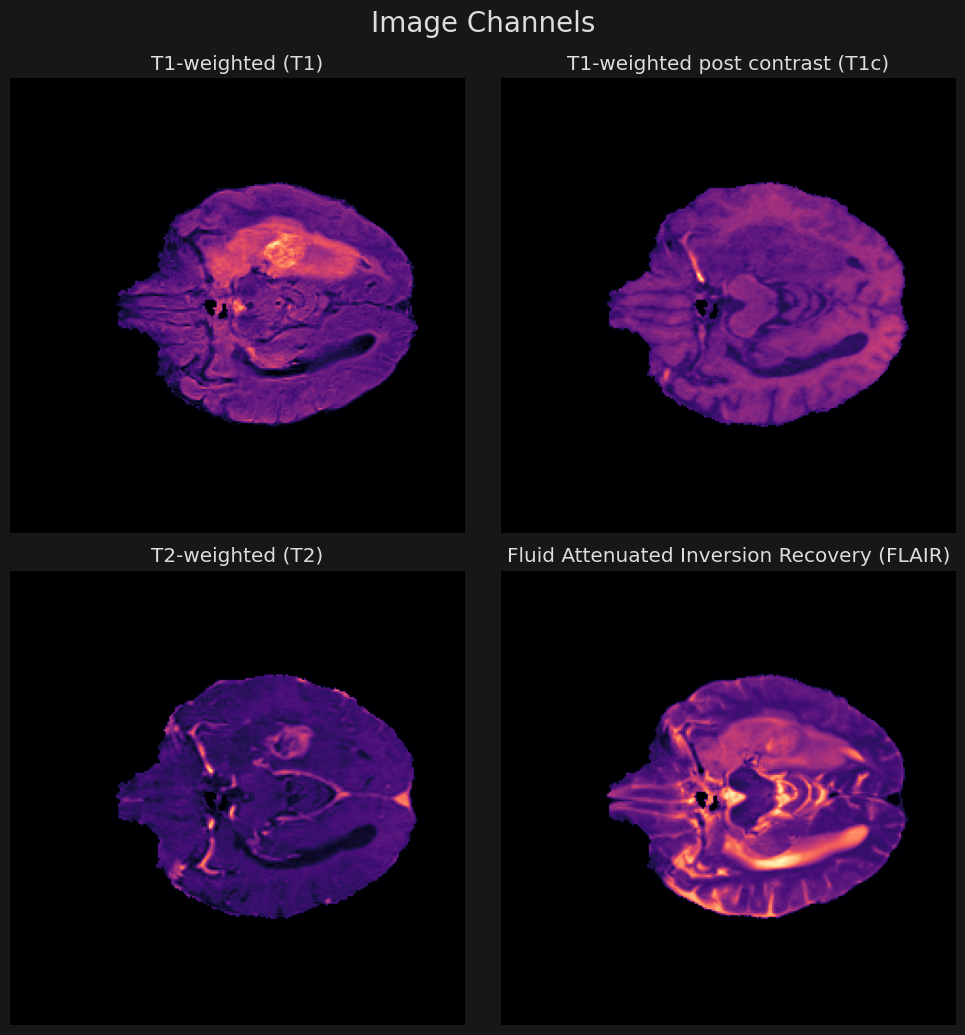

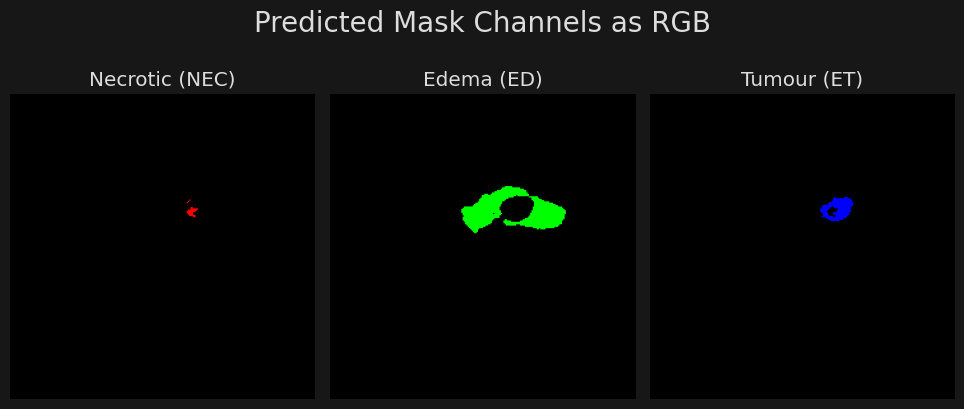

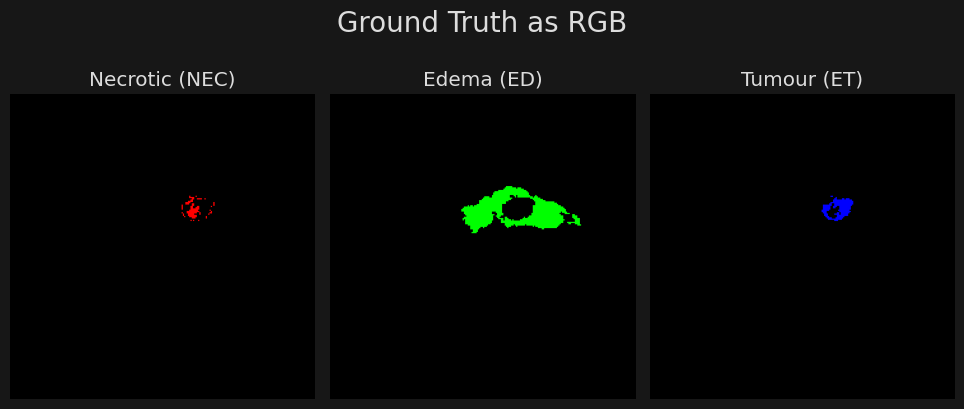

In [52]:
test_input, test_target = next(test_input_iterator)
display_test_sample(model, test_input, test_target)


## Upgraded UNet
Our current UNet model is smaller than the model used in [UNet](https://arxiv.org/abs/1505.04597), but our model already has a fairly large 5.5 million parameters. Instead of directly increasing the size of our model, we'll work in some more modern computer vision tweaks to it that should improve performance.

#### Separable convolution layers
Popularised by Chollet in [Xception](https://arxiv.org/abs/1610.02357), we're going to use separable convolution layers rather than conventional convolution layers.

#### Batch normalisation
Batch norm has become a staple inclusion in most convnet architectures.

#### Larger kernel sizes
[ConvNeXt](https://arxiv.org/abs/2201.03545) found that using larger kernel sizes of (7x7) outperformed 3x3 kernels in their experiments. We'll adopt this change.

#### Inverse bottlenecks
From [MobileNetV2](https://arxiv.org/abs/1801.04381), we're going to use inverse bottlenecks after our depthwise convolution, to improve the parameter efficiency in our model.

#### Additive skip connections
Rather than using a concat skip connection, we'll use an additive one. (torch.add) This change reduces the number of parameters as well and should give the model a clearer residual signal.

#### Learning rate decay
A standard inclusion to help more powerful models refine their predictions.

### 5 points

In [27]:
k_size = 3
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        #expansion_ratio = 2   # use it to scale number of channels
        
        self.encoder_block = nn.Sequential( 
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=7, stride=1, padding=3, groups=in_channels), # convnext-like
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=k_size, stride=1, padding=1),  # separable 1x1
            activation,
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=k_size, stride=1, padding=1),  #  
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=7, stride=1, padding=3, groups=out_channels),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=k_size, stride=1, padding=1),
            activation,
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=k_size, stride=1, padding=1),
        )
    def forward(self, x):
        return self.encoder_block(x)
    
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        #expansion_ratio = 4
        self.decoder_block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=7, stride=1, padding=3, groups=out_channels), # convnext-like
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=k_size, stride=1, padding=1),  # separable 1x1
            activation,
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=k_size, stride=1, padding=1),  #  
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=7, stride=1, padding=3, groups=out_channels),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=k_size, stride=1, padding=1),
            activation,
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=k_size, stride=1, padding=1),
            )
    def forward(self, x):
        return self.decoder_block(x)
    

class UNet2(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Config
        in_channels  = 4   # Input images have 4 channels
        out_channels = 3   # Mask has 3 channels
        n_filters    = 32  # Scaled down from 64 in original paper
        activation   = nn.ReLU() 
        # Up and downsampling methods
        self.downsample  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.upsample    = nn.UpsamplingBilinear2d(scale_factor=2)
        
        # Encoder
        self.enc_block_1 =  EncoderBlock(in_channels, n_filters, activation=activation)
        self.enc_block_2 =  EncoderBlock(n_filters, n_filters*2, activation=activation)
        self.enc_block_3 =  EncoderBlock(n_filters*2, n_filters*4, activation=activation)
        self.enc_block_4 =  EncoderBlock(n_filters*4, n_filters*8, activation=activation)
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(8*n_filters, 8*n_filters, kernel_size=7, stride=1, padding=3, groups=8*n_filters),
            nn.BatchNorm2d(8*n_filters),
            nn.Conv2d(8*n_filters, 4*8*n_filters, kernel_size=1, stride=1),
            activation,
            nn.Conv2d(4*8*n_filters,   8*n_filters, kernel_size=1, stride=1),
            nn.Conv2d(8*n_filters, 8*n_filters, kernel_size=7, stride=1, padding=3, groups=8*n_filters),
            nn.BatchNorm2d(8*n_filters),
            nn.Conv2d(8*n_filters, 4*8*n_filters, kernel_size=1, stride=1),
            activation,
            nn.Conv2d(4*8*n_filters, 8*n_filters, kernel_size=1, stride=1),
        )
        
        # Decoder
        self.dec_block_4 =  DecoderBlock(8*n_filters, 4*n_filters, activation=activation)
        self.dec_block_3 =  DecoderBlock(4*n_filters, 2*n_filters, activation=activation)
        self.dec_block_2 =  DecoderBlock(2*n_filters, n_filters, activation=activation)
        self.dec_block_1 =  DecoderBlock(n_filters, n_filters, activation=activation)
        
        # Output projection
        self.output = nn.Conv2d(1*n_filters,  out_channels, kernel_size=(1,1), stride=1, padding=0)

    def forward(self, X):
        # Encoder
        e1 = self.enc_block_1(X)
        pool1 = self.downsample(e1)
        e2 = self.enc_block_2(pool1)
        pool2 = self.downsample(e2)
        e3 = self.enc_block_3(pool2)
        pool3 = self.downsample(e3)
        e4 = self.enc_block_4(pool3)
        pool4 = self.downsample(e4)
        
        
        # Bottleneck
        x = self.bottleneck(pool4)
        
        # Decoder
        up1 = self.upsample(x)
        d1 = self.dec_block_4(torch.add(up1, e4))
        up2 = self.upsample(d1)
        d2 = self.dec_block_3(torch.add(up2, e3))
        up3 = self.upsample(d2)
        d3 = self.dec_block_2(torch.add(up3, e2))
        up4 = self.upsample(d3)
        d4 = self.dec_block_1(torch.add(up4, e1))
        x = self.output(d4)
        return x

### Training Loop
Identical to the previous one, only with learning rate decay.

In [28]:
# Delete old model and clear GPU cache to release memory
del model
torch.cuda.empty_cache()

In [29]:
model = UNet2()

In [30]:
summary(model,
        input_size=(16, 4, 240, 240), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
UNet2 (UNet2)                            [16, 4, 240, 240]    [16, 3, 240, 240]    --                   True
├─EncoderBlock (enc_block_1)             [16, 4, 240, 240]    [16, 32, 240, 240]   --                   True
│    └─Sequential (encoder_block)        [16, 4, 240, 240]    [16, 32, 240, 240]   29,408               True
│    │    └─Conv2d (0)                   [16, 4, 240, 240]    [16, 32, 240, 240]   1,600                True
│    │    └─BatchNorm2d (1)              [16, 32, 240, 240]   [16, 32, 240, 240]   64                   True
│    │    └─Conv2d (2)                   [16, 32, 240, 240]   [16, 32, 240, 240]   9,248                True
├─DecoderBlock (dec_block_1)             --                   --                   (recursive)          True
│    └─Sequential (decoder_block)        --                   --                   (recursive)          True
│    │    └─Re

In [200]:
max_epochs = 10
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, 4, gamma=0.5) 
history_model = train_model(model, train_dataloader, val_dataloader, optim, nn.BCEWithLogitsLoss(), 
                            scheduler=scheduler, n_epochs=max_epochs, train_batches_per_epoch=1000, 
                            val_batches_per_epoch=250, verbose=True)

Training...
Train batch: 1000/1000
Epoch: 1, Train loss: 0.013526, Val loss: 0.006556

Train batch: 1000/1000
Epoch: 2, Train loss: 0.006486, Val loss: 0.006262

Train batch: 1000/1000
Epoch: 3, Train loss: 0.005378, Val loss: 0.005045

Train batch: 1000/1000
Epoch: 4, Train loss: 0.004950, Val loss: 0.004981

Train batch: 1000/1000
Epoch: 5, Train loss: 0.004680, Val loss: 0.004181

Train batch: 1000/1000
Epoch: 6, Train loss: 0.004515, Val loss: 0.004438

Train batch: 1000/1000
Epoch: 7, Train loss: 0.004235, Val loss: 0.004258

Train batch: 1000/1000
Epoch: 8, Train loss: 0.004222, Val loss: 0.003790

Train batch: 1000/1000
Epoch: 9, Train loss: 0.004031, Val loss: 0.003758

Train batch: 1000/1000
Epoch: 10, Train loss: 0.004033, Val loss: 0.003864

Training complete.


In [ ]:
#torch.save(model.state_dict(), 'model_weights_unet2.pth')
model.load_state_dict(torch.load('/kaggle/input/unet2-weights/model_weights_unet2.pth'))

In [202]:
FileLink(r'model_weights_unet2.pth') 

/kaggle/working/model_weights_unet2.pth

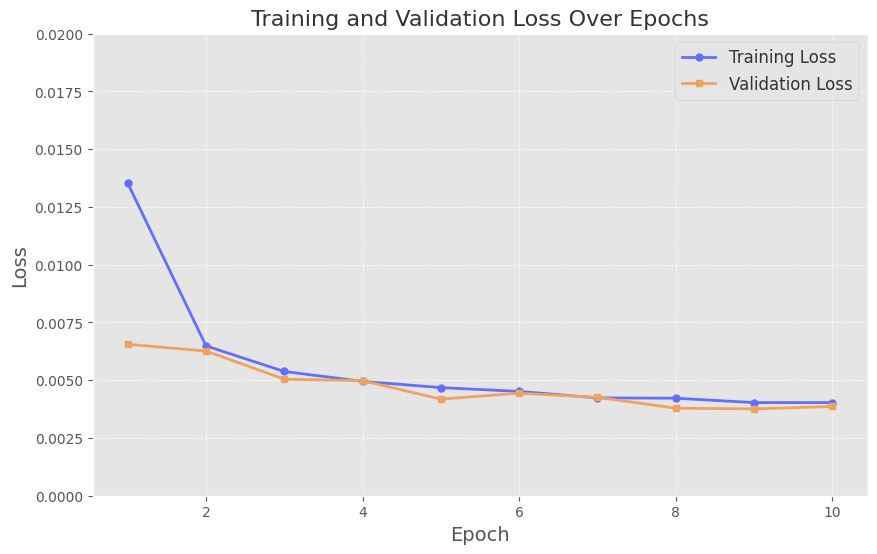

In [203]:
plot_learning_curves(history_model[0], history_model[1], (0, 0.02))

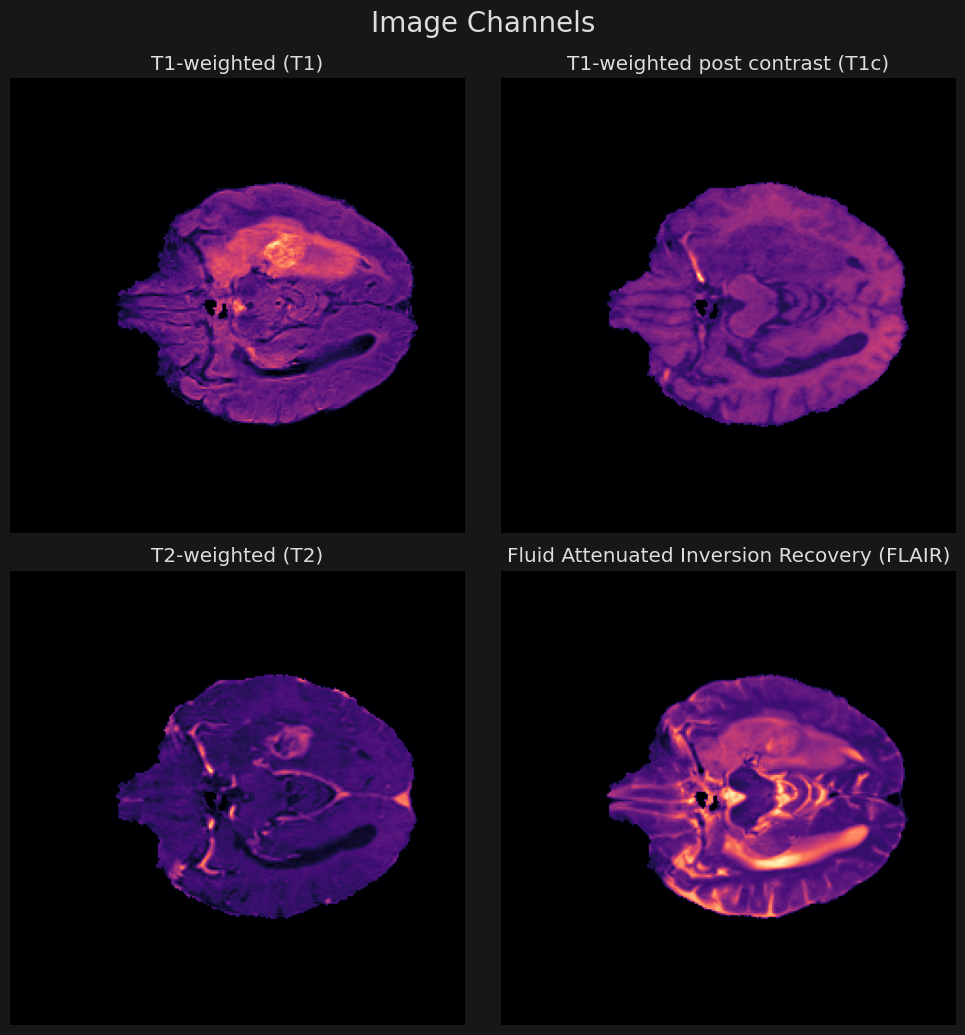

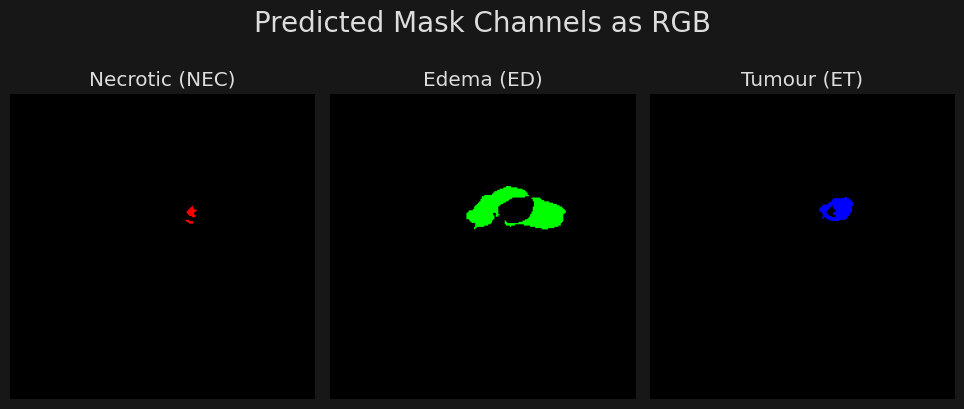

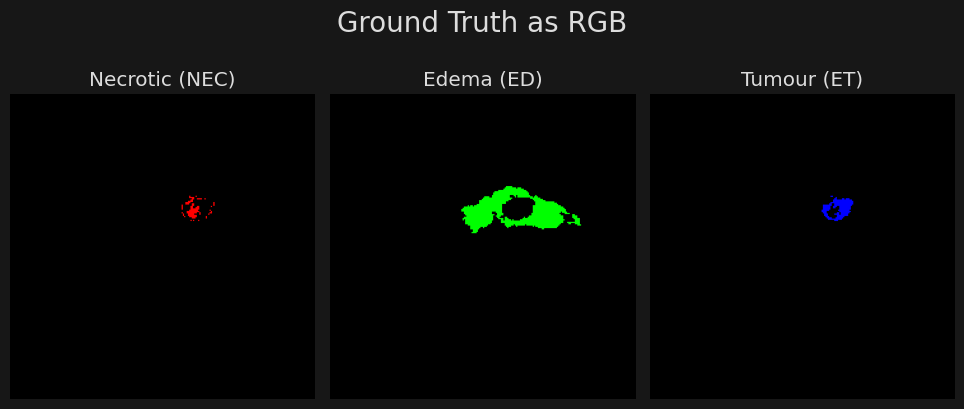

In [213]:
test_input, test_target = next(test_input_iterator)
display_test_sample(model, test_input, test_target)

## Let's calculate IoU

In [33]:
score_model(model, iou_pytorch, test_dataloader, 3)

IoU for Necrosis: 0.84
IoU for Edema: 0.79
IoU for Tumor: 0.88
Average IoU score: 0.835


# BONUS PART, NO GRADES

## Attention UNet
[Attention UNet](https://arxiv.org/abs/1804.03999) is a modified version of the UNet architecture that incorporates an attention mechanism into the basic UNet.

<img src="https://i.imgur.com/nI10XH4.png" 
     align="center" 
     width="700"
     style="padding: 20px;" />

Since the architecture presented in the original [Attention UNet](https://arxiv.org/abs/1804.03999) paper includes many of the dated UNet elements, we're going to build it into our modernised UNet.

The attention mechanism will be implemented over the skip connection, allowing our model to be able to allocate more resources to relevant regions, and 'tune out' the less important parts. The model will learn what to pay attention to during training.

<img src="https://i.imgur.com/bZrJrzT.png" 
     align="center" 
     width="700"
     style="padding: 20px;" />
     
To explain attention in the context of our image segmentation UNet:

The encoder has good spatial representation but worse feature representation. The decoder has strong feature representations, but may have lost spatial representations as the input moves deeper into the network.

The attention process begins with the *query* (marked with $g$ for *gate* in the diagram), which is derived from the decoder's feature maps. These feature maps are expected to contain a rich representation of the target structure due to the progressive decoding process.

The *key* is generated from the encoder's feature maps (marked $x$ in the diagram), which capture the input image's contextual information. The goal is to identify regions in the encoder's features that are relevant to the query from the decoder. 

The *query* and the *key* interact to produce the attention map. This map acts as a filter, highlighting areas to focus on. The attention mechanism computes this by aligning the query with the key, resulting in weights that signify the importance of each feature in the encoder's output.

The *value*, which is also derived from the encoder's feature maps, represents the content that we want to enhance or suppress. The attention map is applied to the *value* through element-wise multiplication, which scales the features accordingly. Features that are deemed relevant by the attention map are emphasized, while others are diminished.

This produces a weighted feature representation where the focus is directed toward the most informative parts of the input, thereby refining the information flow in the network and improving the quality of the segmentation output.

The attention mechanism effectively guides the model to pay more attention to specific areas of the feature maps, ensuring that the final output is more precise and relevant to the segmentation task.

### Building an Attention UNet Model
We'll build the attention mechanism into our custom-build UNet.

There are a few minor differences in how attention is implemented in our model, as we are adding the attended encoder features to the opposite decoder block's feature maps, rather than concatenating them. This approach should just perform better as well as reduce model parameters.

In [46]:
#NEEEEEEEW
class AttentionBlock(nn.Module):
    def __init__(self, f_g, f_l, f_int):
        super().__init__()
        
        self.w_g = nn.Sequential(
                                nn.Conv2d(f_g, f_int, kernel_size=1, stride=1, padding=0, bias=True),
                                nn.BatchNorm2d(f_int)
        )
        
        self.w_x = nn.Sequential(
                                nn.Conv2d(f_l, f_int, kernel_size=1, stride=1, padding=0, bias=True),
                                nn.BatchNorm2d(f_int)
        )
        
        self.psi = nn.Sequential(
                                nn.Conv2d(f_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
                                nn.BatchNorm2d(1),
                                nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, g, x):
        g1 = self.w_g(g)
        x1 = self.w_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)
        
        return psi*x
    
k_size = 3
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.encoder_block = nn.Sequential( 
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=7, stride=1, padding=3, groups=in_channels), # convnext-like
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=k_size, stride=1, padding=1),  # separable 1x1
            activation,
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=k_size, stride=1, padding=1),  #  
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=7, stride=1, padding=3, groups=out_channels),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=k_size, stride=1, padding=1),
            activation,
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=k_size, stride=1, padding=1),
        )
    def forward(self, x):
        return self.encoder_block(x)
    
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__() 
        self.decoder_block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=7, stride=1, padding=3, groups=out_channels), # convnext-like
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=k_size, stride=1, padding=1),  # separable 1x1
            activation,
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=k_size, stride=1, padding=1),  #  
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=7, stride=1, padding=3, groups=out_channels),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=k_size, stride=1, padding=1),
            activation,
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=k_size, stride=1, padding=1),
            )
    def forward(self, x):
        return self.decoder_block(x)
    

class AttentionUNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=3, n_filters=32, activation=nn.ReLU(inplace=True)):
        super().__init__()

        # Up and downsampling methods
        self.downsample  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.upsample    = nn.UpsamplingBilinear2d(scale_factor=2)
        
        # Encoder
        self.enc_block_1 =  EncoderBlock(in_channels, n_filters, activation=activation)
        self.enc_block_2 =  EncoderBlock(n_filters, n_filters*2, activation=activation)
        self.enc_block_3 =  EncoderBlock(n_filters*2, n_filters*4, activation=activation)
        self.enc_block_4 =  EncoderBlock(n_filters*4, n_filters*8, activation=activation)
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(8*n_filters, 8*n_filters, kernel_size=7, stride=1, padding=3, groups=8*n_filters),
            nn.BatchNorm2d(8*n_filters),
            nn.Conv2d(8*n_filters, 4*8*n_filters, kernel_size=1, stride=1),
            activation,
            nn.Conv2d(4*8*n_filters,   8*n_filters, kernel_size=1, stride=1),
            nn.Conv2d(8*n_filters, 8*n_filters, kernel_size=7, stride=1, padding=3, groups=8*n_filters),
            nn.BatchNorm2d(8*n_filters),
            nn.Conv2d(8*n_filters, 4*8*n_filters, kernel_size=1, stride=1),
            activation,
            nn.Conv2d(4*8*n_filters, 8*n_filters, kernel_size=1, stride=1),
        )
        
        # Decoder
        self.att4 = AttentionBlock(f_g=8*n_filters, f_l=8*n_filters, f_int=n_filters*4)
        self.dec_block_4 =  DecoderBlock(8*n_filters, 4*n_filters, activation=activation)
        
        self.att3 = AttentionBlock(f_g=4*n_filters, f_l=4*n_filters, f_int=n_filters*2)
        self.dec_block_3 =  DecoderBlock(4*n_filters, 2*n_filters, activation=activation)
        
        self.att2 = AttentionBlock(f_g=2*n_filters, f_l=2*n_filters, f_int=n_filters)
        self.dec_block_2 =  DecoderBlock(2*n_filters, n_filters, activation=activation)
        
        self.att1 = AttentionBlock(f_g=n_filters, f_l=n_filters, f_int=int(n_filters/2))
        self.dec_block_1 =  DecoderBlock(n_filters, n_filters, activation=activation)
        
        # Output projection
        self.output = nn.Conv2d(1*n_filters,  out_channels, kernel_size=(1,1), stride=1, padding=0)

    def forward(self, X):
        # Encoder
        e1 = self.enc_block_1(X)
        pool1 = self.downsample(e1)
        e2 = self.enc_block_2(pool1)
        pool2 = self.downsample(e2)
        e3 = self.enc_block_3(pool2)
        pool3 = self.downsample(e3)
        e4 = self.enc_block_4(pool3)
        pool4 = self.downsample(e4)
        
        
        # Bottleneck
        x = self.bottleneck(pool4)
        
        # Decoder
        up4 = self.upsample(x)
        att4 = self.att4(g = up4, x = e4)
        d4 = self.dec_block_4(torch.add(att4, up4))
        
        up3 = self.upsample(d4)
        att3 = self.att3(g = up3, x = e3)
        d3 = self.dec_block_3(torch.add(att3, up3))
        
        up2 = self.upsample(d3)
        att2 = self.att2(g = up2, x = e2)
        d2 = self.dec_block_2(torch.add(att2, up2))
        
        up1 = self.upsample(d2)
        att1 = self.att1(g = up1, x = e1)
        d1 = self.dec_block_1(torch.add(att1, up1))
        
        x = self.output(d1)

        return x

In [47]:
'''
class EncoderBlock(nn.Module):
    def __init__(self, ch_in, ch_out, activation=nn.ReLU(inplace=True)):
        super().__init__()
        self.conv = nn.Sequential(
                                  nn.Conv2d(ch_in, ch_out, kernel_size=7, stride=1, padding=3, bias=True),
                                  nn.BatchNorm2d(ch_out),
                                  activation,
                                  nn.Conv2d(ch_out, ch_out, kernel_size=7, stride=1, padding=3, bias=True),
                                  nn.BatchNorm2d(ch_out),
                                  activation
        )
        
    def forward(self, x):
        x = self.conv(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, ch_in, ch_out, activation=nn.ReLU(inplace=True)):
        super().__init__()
        self.up = nn.Sequential(
                                nn.Upsample(scale_factor=2),
                                nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1, padding=1, bias=True),
                                nn.BatchNorm2d(ch_out),
                                activation
        )
        
    def forward(self, x):
        x = x = self.up(x)
        return x
class AttentionBlock(nn.Module):
    def __init__(self, f_g, f_l, f_int):
        super().__init__()
        
        self.w_g = nn.Sequential(
                                nn.Conv2d(f_g, f_int, kernel_size=1, stride=1, padding=0, bias=True),
                                nn.BatchNorm2d(f_int)
        )
        
        self.w_x = nn.Sequential(
                                nn.Conv2d(f_l, f_int, kernel_size=1, stride=1, padding=0, bias=True),
                                nn.BatchNorm2d(f_int)
        )
        
        self.psi = nn.Sequential(
                                nn.Conv2d(f_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
                                nn.BatchNorm2d(1),
                                nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, g, x):
        g1 = self.w_g(g)
        x1 = self.w_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)
        
        return psi*x
class AttentionUNet(nn.Module):
    def __init__(self, in_channel=3, out_channel=1, n_filters=64, activation=nn.ReLU(inplace=True)):
        super().__init__() 
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv1 = EncoderBlock(ch_in=in_channel, ch_out=n_filters, activation=activation)
        self.conv2 = EncoderBlock(ch_in=n_filters, ch_out=n_filters*2, activation=activation)
        self.conv3 = EncoderBlock(ch_in=n_filters*2, ch_out=n_filters*4, activation=activation)
        self.conv4 = EncoderBlock(ch_in=n_filters*4, ch_out=n_filters*8, activation=activation)
        self.conv5 = EncoderBlock(ch_in=n_filters*8, ch_out=n_filters*16, activation=activation)
        
        self.up5 = DecoderBlock(ch_in=n_filters*16, ch_out=n_filters*8, activation=activation)
        self.att5 = AttentionBlock(f_g=n_filters*8, f_l=n_filters*8, f_int=n_filters*4)
        self.upconv5 = EncoderBlock(ch_in=n_filters*8, ch_out=n_filters*8, activation=activation)
        
        self.up4 = DecoderBlock(ch_in=n_filters*8, ch_out=n_filters*4, activation=activation)
        self.att4 = AttentionBlock(f_g=n_filters*4, f_l=n_filters*4, f_int=n_filters*2)
        self.upconv4 = EncoderBlock(ch_in=n_filters*4, ch_out=n_filters*4, activation=activation)
        
        self.up3 = DecoderBlock(ch_in=n_filters*4, ch_out=n_filters*2, activation=activation)
        self.att3 = AttentionBlock(f_g=n_filters*2, f_l=n_filters*2, f_int=n_filters)
        self.upconv3 = EncoderBlock(ch_in=n_filters*2, ch_out=n_filters*2, activation=activation)
        
        self.up2 = DecoderBlock(ch_in=n_filters*2, ch_out=n_filters, activation=activation)
        self.att2 = AttentionBlock(f_g=n_filters, f_l=n_filters, f_int=int(n_filters/2))
        self.upconv2 = EncoderBlock(ch_in=n_filters, ch_out=n_filters, activation=activation)
        
        self.conv_1x1 = nn.Conv2d(n_filters, out_channel,
                                  kernel_size=1, stride=1, padding=0)
        
    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        
        x2 = self.maxpool(x1)
        x2 = self.conv2(x2)
        
        x3 = self.maxpool(x2)
        x3 = self.conv3(x3)
        
        x4 = self.maxpool(x3)
        x4 = self.conv4(x4)
        
        x5 = self.maxpool(x4)
        x5 = self.conv5(x5)
        
        # decoder + concat
        d5 = self.up5(x5)
        x4 = self.att5(g=d5, x=x4)
        d5 = torch.add(x4, d5)
        d5 = self.upconv5(d5)
        
        d4 = self.up4(d5)
        x3 = self.att4(g=d4, x=x3)
        d4 = torch.add(x3, d4)
        d4 = self.upconv4(d4)
        
        d3 = self.up3(d4)
        x2 = self.att3(g=d3, x=x2)
        d3 = torch.add(x2, d3)
        d3 = self.upconv3(d3)
        
        d2 = self.up2(d3)
        x1 = self.att2(g=d2, x=x1)
        d2 = torch.add(x1, d2)
        d2 = self.upconv2(d2)
        
        d1 = self.conv_1x1(d2)
        
        return d1
'''

### Training Loop
In this training loop we increase the number of epochs to 25 and slightly increase the learning rate decay constant to accommodate for this greater number of epochs.

In [66]:
# Delete old model and clear GPU cache to release memory
del model
torch.cuda.empty_cache()

In [67]:
model = AttentionUNet(in_channels=4, out_channels=3, n_filters=64)

In [68]:
summary(model,
        input_size=(16, 4, 240, 240), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AttentionUNet (AttentionUNet)            [16, 4, 240, 240]    [16, 3, 240, 240]    --                   True
├─EncoderBlock (enc_block_1)             [16, 4, 240, 240]    [16, 64, 240, 240]   --                   True
│    └─Sequential (encoder_block)        [16, 4, 240, 240]    [16, 64, 240, 240]   114,112              True
│    │    └─Conv2d (0)                   [16, 4, 240, 240]    [16, 64, 240, 240]   3,200                True
│    │    └─BatchNorm2d (1)              [16, 64, 240, 240]   [16, 64, 240, 240]   128                  True
│    │    └─Conv2d (2)                   [16, 64, 240, 240]   [16, 64, 240, 240]   36,928               True
├─DecoderBlock (dec_block_1)             --                   --                   (recursive)          True
│    └─Sequential (decoder_block)        --                   --                   (recursive)          True
│    │    └─Re

In [69]:
max_epochs = 10
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, 4, gamma=0.5) 
history_model = train_model(model, train_dataloader, val_dataloader, optim, nn.BCEWithLogitsLoss(), 
                            scheduler=scheduler, n_epochs=max_epochs, train_batches_per_epoch=1000, 
                            val_batches_per_epoch=50, verbose=True)

Training...
Train batch: 1000/1000
Epoch: 1, Train loss: 0.011324, Val loss: 0.005998

Train batch: 1000/1000
Epoch: 2, Train loss: 0.006070, Val loss: 0.006538

Train batch: 1000/1000
Epoch: 3, Train loss: 0.005251, Val loss: 0.005097

Train batch: 1000/1000
Epoch: 4, Train loss: 0.004978, Val loss: 0.004479

Train batch: 1000/1000
Epoch: 5, Train loss: 0.004276, Val loss: 0.004294

Train batch: 1000/1000
Epoch: 6, Train loss: 0.004288, Val loss: 0.003603

Train batch: 1000/1000
Epoch: 7, Train loss: 0.004018, Val loss: 0.004196

Train batch: 1000/1000
Epoch: 8, Train loss: 0.003839, Val loss: 0.003531

Train batch: 1000/1000
Epoch: 9, Train loss: 0.003505, Val loss: 0.003173

Train batch: 1000/1000
Epoch: 10, Train loss: 0.003399, Val loss: 0.003071

Training complete.


In [70]:
torch.save(model.state_dict(), 'model_weights_unet3.pth')
#model.load_state_dict(torch.load('/kaggle/input/unet3-weights/model_weights_unet3.pth'))

In [73]:
FileLink(r'model_weights_unet3.pth') 

/kaggle/working/model_weights_unet3.pth

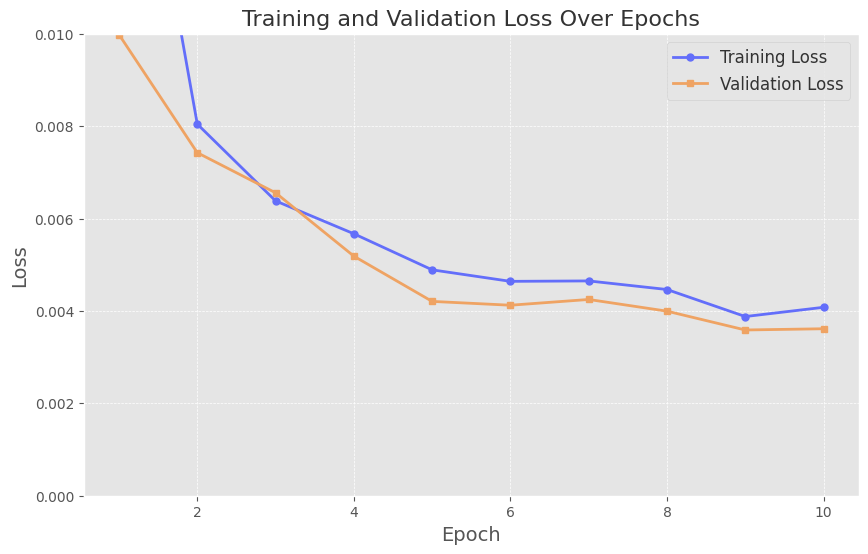

In [54]:
plot_learning_curves(history_model[0], history_model[1], (0, 0.01))

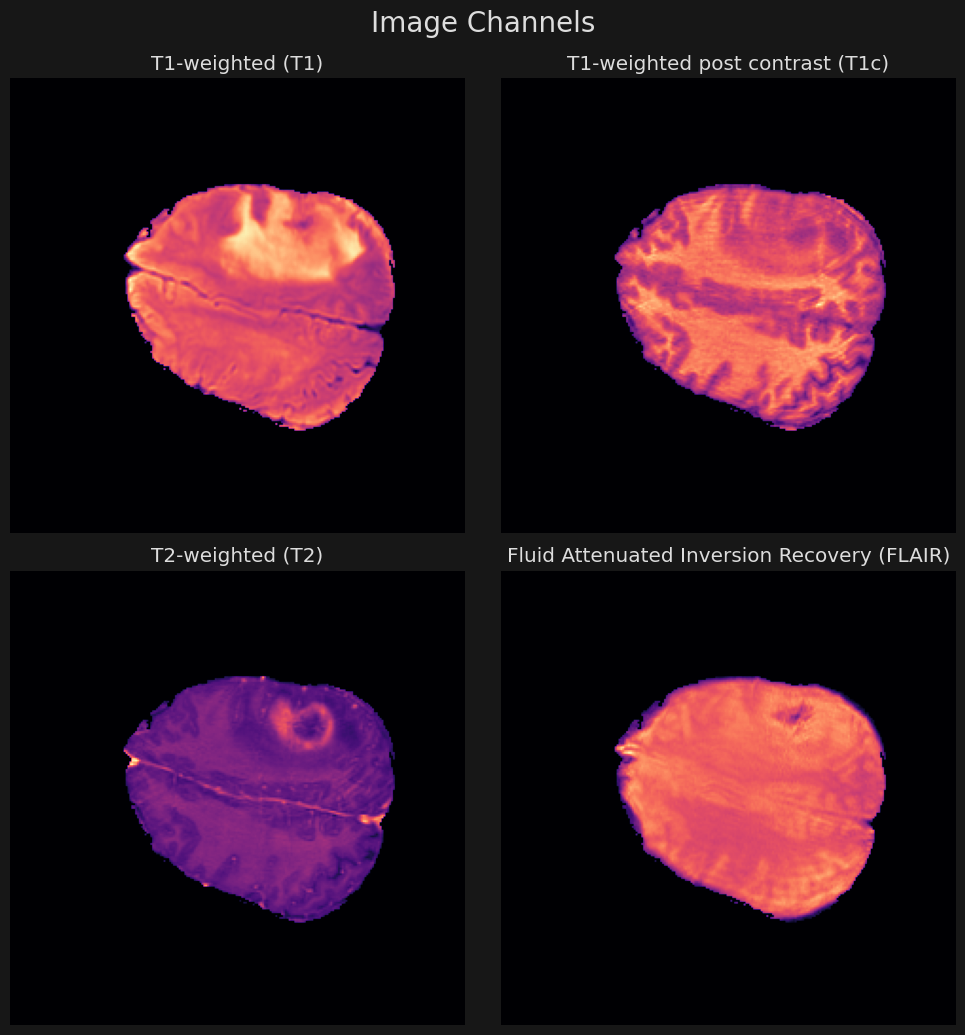

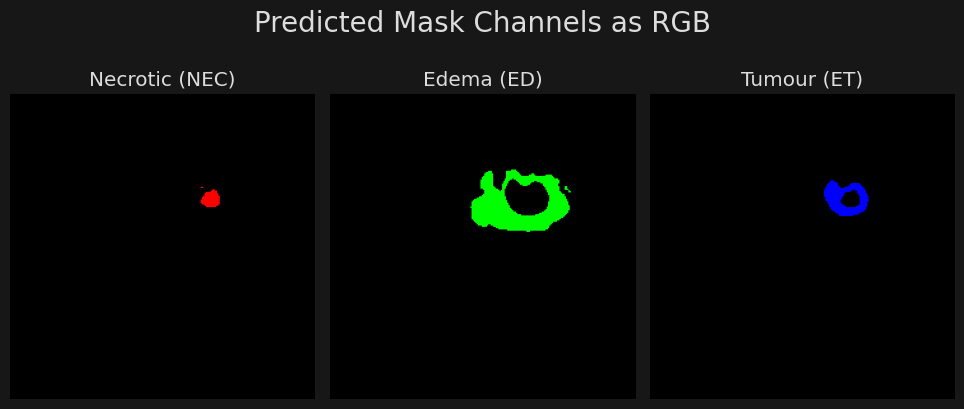

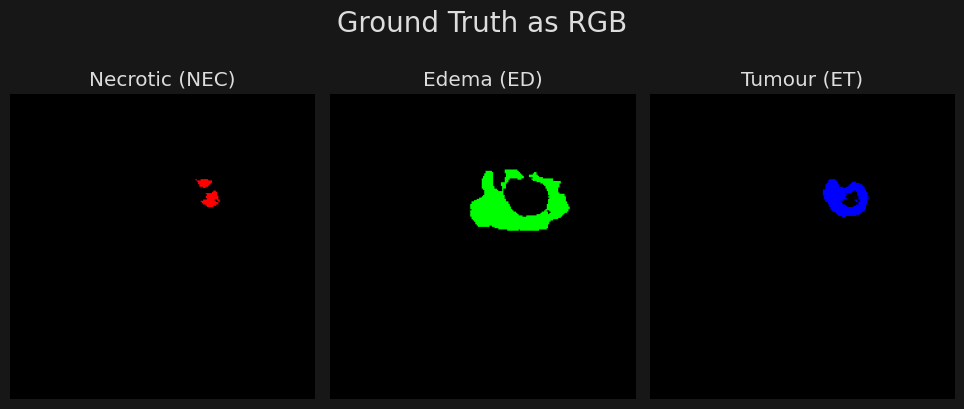

In [75]:
test_input, test_target = next(test_input_iterator)
display_test_sample(model, test_input, test_target)

In [76]:
score_model(model, iou_pytorch, test_dataloader, 3)

IoU for Necrosis: 0.85
IoU for Edema: 0.81
IoU for Tumor: 0.88
Average IoU score: 0.847
